In [1]:
import numpy as np
import matplotlib.pyplot as plt
import estraces as es
plt.rcParams["figure.figsize"] = [20, 5]

In [2]:
ths = es.read_ths_from_ets_file("AES_traces_set_1st_round.ets")

In [3]:
ths.traces[0]

Trace:
Reader instance..: ETS format reader of file AES_traces_set_1st_round.ets with 2000 traces.
Index in set.....: 0
Samples size.....: 3000
ciphertext.......: [ 61  49 209 113 171 142 254 187  55 149 142 126   7 238 160 148]
key..............: [143   3 231 122 236 102  88  10  19  43 210  59 245  99  78  15]
plaintext........: [ 22 171 243 171  89  17  13 120 142  59 128  13 226 133 132 203]

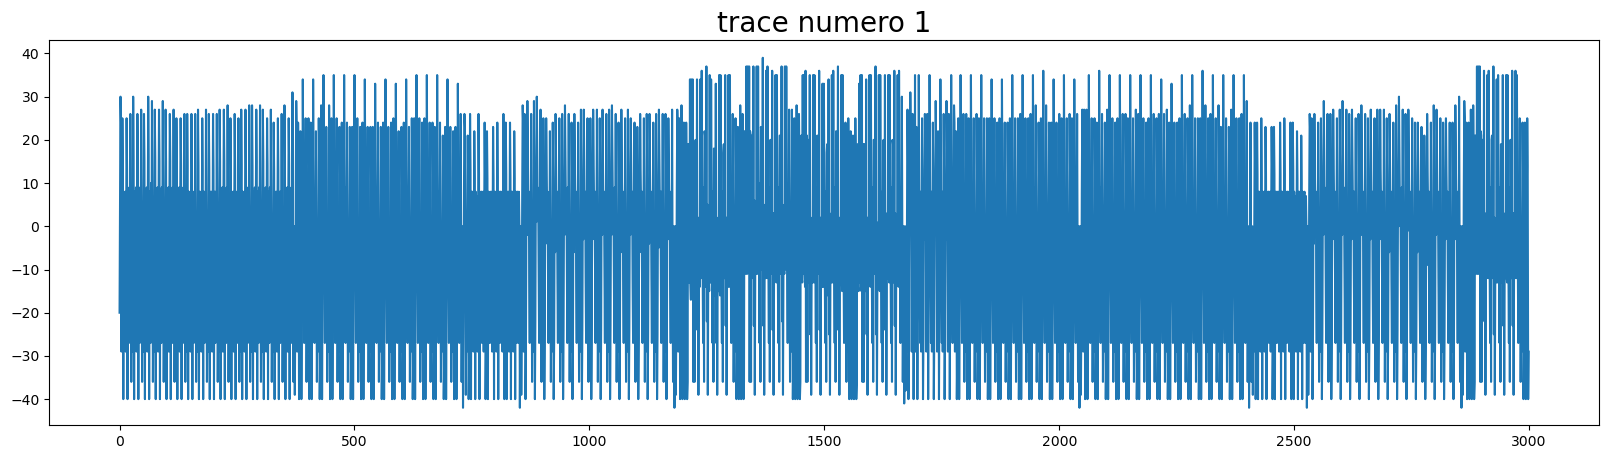

In [4]:
plt.title("trace numero 1", fontsize=20)
plt.plot(ths.traces[0].samples[:])

## AES S-Box utilisée pour le calcul des valeurs intermédiaires

In [5]:
SBOX = np.array([
    0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
    0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
    0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
    0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
    0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
    0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
    0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
    0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
    0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
    0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
    0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
    0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
    0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
    0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
    0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
    0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16],
    dtype=np.uint8)

In [6]:
def guess_octet(data, k): 
    matrix =[0 for i in range(256)]
    for i in range(256):
        matrix[i] = [SBOX[data[j][k] ^ i] for j in range(len(data))]
    return np.array(matrix)

In [132]:
def bit_classifier(data):
    set_0 = []
    set_1 = []
    for i in range(len(data)):
        if data[i]>>7:
            set_1.append(ths.traces[i].samples)
        else:
            set_0.append(ths.traces[i].samples)
    return np.abs(np.mean(set_0, axis=0) - np.mean(set_1, axis=0))

In [133]:
def DPA_Attack_one_octect(data, oct):
    matrix = guess_octet(data, oct)
    delta = []
    for row in matrix:
        delta.append(bit_classifier(row)) 
    guess = []
    for i in range(256): 
        guess.append(delta[i])  
    return [[row,i] for i, row in enumerate(guess) if np.max(guess) in row]

In [134]:
test = DPA_Attack_one_octect(ths.plaintext,0)

In [135]:
test[0][1]

143

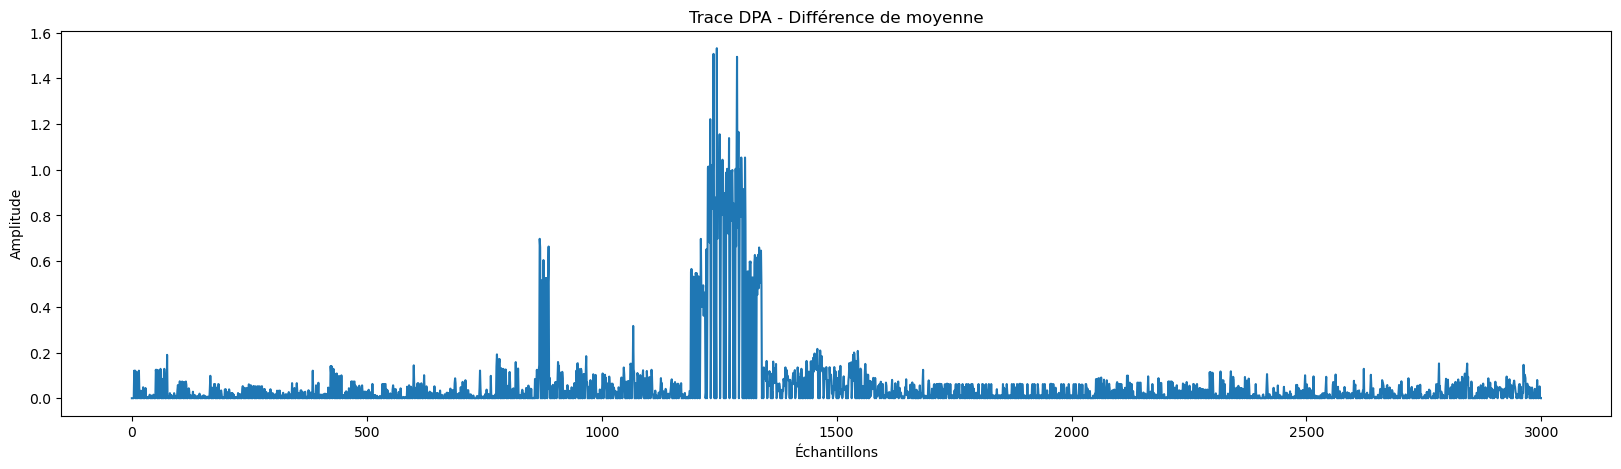

In [128]:
plt.plot(test[0][0])
plt.title("Trace DPA - Différence de moyenne")
plt.xlabel("Échantillons")
plt.ylabel("Amplitude")
plt.show()

In [120]:
def DPA_Attack(data):
    return [DPA_Attack_one_octect(data,i)[0][1] for i in range(16)]

In [121]:
key_found = DPA_Attack(ths.plaintext)

In [127]:
print("clé trouvée: ",key_found)
print(" Vraie clé:  ",list(ths.traces[0].key))

clé trouvée:  [143, 3, 231, 122, 236, 102, 88, 10, 19, 43, 210, 59, 245, 99, 78, 15]
 Vraie clé:   [143, 3, 231, 122, 236, 102, 88, 10, 19, 43, 210, 59, 245, 99, 78, 15]
